Based on tensorflow starter code from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
#%pip install pandas
#%pip install keras_tqdm
#%pip install tensorflow-addons
#%pip install tensorflow-io
#%pip install numba
#%pip install tqdm
#%pip install joblib
#%pip install scipy


In [1]:

#import array 
#from sklearn.utils import shuffle

import tensorflow as tf

import tensorflow.keras as keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate, LocallyConnected1D
from keras.layers import Activation, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool2D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Reshape, LSTM, Layer, LayerNormalization, InputLayer, Permute, GRU, Cropping1D
from keras.layers import TimeDistributed, Conv2DTranspose, UpSampling2D, MultiHeadAttention, Embedding, Rescaling, Masking
from keras.layers import ZeroPadding1D, ZeroPadding2D, GaussianNoise, DepthwiseConv2D, Cropping2D, RepeatVector, RNN, AveragePooling2D
from keras.regularizers import l1, l2
from keras import activations, losses
from keras.constraints import max_norm

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import LAMB 

from keras import optimizers
from keras.losses import CategoricalCrossentropy
import numpy as np

import re
import os

from my_layers import ScaleNorm, L1Norm, TransformerBlock, DenseBlock, PositionEmbedding, RandomMask, RestoreUnmaskedTokens
from my_layers import FourierEmbeddingLayer, LinearPositionEmbedding, AugmentAmplitude, ConstantLayer

from random import *
import math


#from tqdm.notebook import tqdm, trange

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import keras.backend as K
import matplotlib.pyplot as plt

import gc as gc

import pandas as pd
import datetime
from datetime import datetime as dt
import time

from collections import deque

from data import get_dataset
from utils import ObjectView


%matplotlib inline

projDir = ''


model_dtype = "float32"

K.set_floatx(model_dtype)
K.set_epsilon(1e-6)
#tf.keras.mixed_precision.experimental.set_policy(model_dtype)

tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.set_visible_devices([], 'GPU') 

DEVICE = "/device:CPU:0"
print("Done")





d:\Apps\Anaconda\envs\TF_GPU\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5911975617245901652
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7365364736
locality {
  bus_id: 1
}
incarnation: 9008266343066540370
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]
Done


TensorShape([60000, 28, 28]) tf.float32
(60000,)
(10000,)
take  <TakeDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))>
TensorShape([28, 28]) tf.float32 151


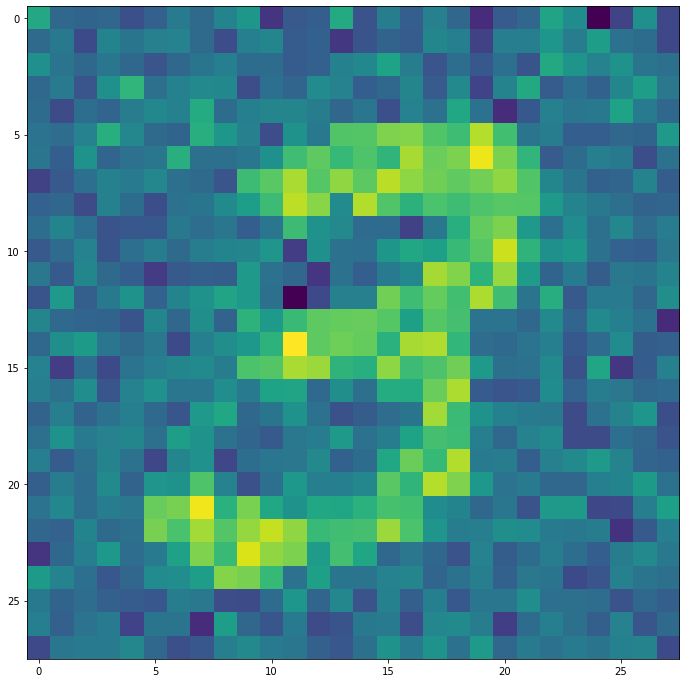

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = tf.cast(x_train, tf.float32) / 255.0

tf.print(x_train.shape, x_train.dtype)
tf.print(y_train.shape)
tf.print(y_test.shape)




@tf.function(jit_compile=False) # random sequencing doesn't work with JIT
def get_random_seq_diffusion(seq : tf.Tensor) -> tf.Tensor:      
    """
    Seq - already normalized <0, 1> time series, len = 512
    """ 

    #sequence_length = 512
    max_steps = 200
    std_mod = 0.001

    no_embed_seq = seq
    
    #seq = (seq - tf.reduce_mean(seq)) / tf.math.reduce_std(seq)
    
    #seq = vec2emb(seq, emb_dim=8)
    #tf.print(tf.shape(seq))
    #### otput: (sequence_length*2, emb_dim*2)
    
    
    #seq = (seq - tf.reduce_mean(seq)) / tf.math.reduce_std(seq)
    
    step = tf.cast(tf.random.uniform([], minval=1, maxval=max_steps, dtype=tf.int32), tf.float32)
    
    #step = 199.0
    
    alpha_t = 1.0
    for i in tf.range(step):
        alpha_t *= 1.0 - i / tf.cast(max_steps, tf.float32) * std_mod
    
    noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev = 1.0, dtype=tf.float32)
    
    X = tf.sqrt(alpha_t) * seq + tf.sqrt(1.0 - alpha_t) * noise
    
    #min_val = tf.math.reduce_min(X)
    #max_val = tf.math.reduce_max(X)
    #X = (X - min_val) / (max_val - min_val + 1e-6) * 2.0 - 1.0
    
    
    
    #X = (X - tf.reduce_mean(X)) / tf.math.reduce_std(X)
    #X = tf.clip_by_value(X, -8.0, 8.0)
    
    
    return X, noise, step, seq, no_embed_seq





diff_dataset = tf.data.Dataset.from_tensor_slices(x_train)

diff_dataset = (
    diff_dataset.repeat()
    .map(get_random_seq_diffusion, num_parallel_calls=16)       # get_random_seq_diffusion, get_random_trade
)

print("take ", diff_dataset.take(1))




X, noise, step, seq, no_embed_seq = get_random_seq_diffusion(x_train[7])

tf.print(X.shape, X.dtype, step)

fig = plt.figure(figsize=(20, 12))
plt.imshow(X)


In [4]:
from keras.callbacks import TensorBoard
exp_name = "diffusion_1"

                
callbacks = [EarlyStopping(monitor='loss',
                           patience=400,
                           verbose=1,
                           mode='min'),
             ReduceLROnPlateau(monitor='loss',
                               factor=0.1,
                               patience=100,
                               verbose=1,
                               min_delta=0.00001,
                               mode='min'),
             TerminateOnNaN(),
             ModelCheckpoint(monitor='loss',
                             filepath= projDir + 'weights/{}'.format(exp_name) + '_{epoch:04d}.hdf5',
                             save_best_only=False,
                             save_freq=5,      # every 5 epochs
                             save_weights_only=True,
                             mode='auto'),
            TensorBoard(log_dir= projDir + './logs', histogram_freq=0, write_graph=True)]

#%load_ext tensorboard
#%tensorboard --logdir gdrive/Shareddrives/edu_VAD/Anton/VAD_project/logs





In [53]:

class UNetBlock2D(Layer):
    def __init__(self, filters, trainable=True,
                name=None, **kwargs):
        super(UNetBlock2D, self).__init__(trainable=trainable, name=name, **kwargs)
        self.filters = filters
        #self.act = tf.nn.leaky_relu

    def build(self, input_shape):
                    
        
        self.residual = Conv2D(filters=int(self.filters), kernel_size=1, use_bias=True, 
                                    kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
        
        self.conv1 = Conv2D(filters=self.filters, kernel_size=3, use_bias=True, padding="SAME",
                                    kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
        
        self.conv2 = Conv2D(filters=self.filters, kernel_size=3, use_bias=True, padding="SAME",
                                    kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
        

        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()

    def call(self, input_x):

        x = self.norm1(input_x)
        x = tf.nn.leaky_relu(x)
        x = self.conv1(x)
        
        x = self.norm2(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        
        if input_x.shape[1:-1] == x.shape[1:-1]:
            x += self.residual(input_x)
        
        return x


    def get_config(self):
        cfg = super(UNetBlock2D, self).get_config()
        cfg.update({'filters': self.filters})
        return cfg
    
    
    
################################ encoder

sequence_length = 512
embed_dim = 16

patch_size = 4



inp = Input(shape=[28, 28])
x = inp

x = Reshape([28, 28, 1])(x)



x128 = Conv2D(embed_dim, 3, activation="ReLU", padding="same")(x)

x64 = MaxPooling2D((2, 2))(x128)
x64 = UNetBlock2D(embed_dim)(x64)

x32 = MaxPooling2D((2, 2))(x64)
x32 = UNetBlock2D(embed_dim)(x32)

x16 = MaxPooling2D((2, 2))(x32)
x16 = UNetBlock2D(embed_dim)(x16)
x16 = Flatten()(x16)

x16 = Dense(64, activation = 'ReLU')(x16)
x16 = Dense(7*7*embed_dim, activation = 'ReLU')(x16)
y32 = Reshape([7, 7, embed_dim])(x16)


y32 = UNetBlock2D(embed_dim)(y32)
y64 = Conv2DTranspose(embed_dim, kernel_size=4, strides=2, padding="SAME")(y32)        # upsample
y64 = y64 + x64

y64 = UNetBlock2D(embed_dim)(y64)
y128 = Conv2DTranspose(embed_dim, kernel_size=4, strides=2, padding="SAME")(y64)        # upsample
y128 = y128 + x128
y128 = UNetBlock2D(embed_dim)(y128)


x = Dense(32, activation = 'ReLU')(y128)
x = Dense(1, activation = 'linear')(x)
















x = Reshape([28, 28])(x)

outp = x





encoder = Model(inp, outp, name="encoder")



opt = LAMB(learning_rate=0.001)

#loss = CategoricalCrossentropy(label_smoothing=0.0)

#encoder.compile(optimizer=opt, loss="MSE")     # tf.keras.losses.MSE
#encoder.build(input_shape=[None, sequence_length])


encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 reshape_39 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 4)         580       
                                                                 
 flatten_14 (Flatten)        (None, 3136)              0         
                                                                 
 dense_48 (Dense)            (None, 784)               2459

In [35]:




#x = RestoreUnmaskedTokens()([x, mask_input, mask])
#x = Conv2DTranspose(32, kernel_size=(3, inp_dim), strides=(2, 1), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="SAME")(x)
#x = Conv2D(32, (3, inp_dim), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="same")(x)
#x = Conv2DTranspose(1, kernel_size=1, strides=1, activation="linear", padding="SAME", dtype='float32')(x)
#x = Cropping1D([0, predict_len])(x)
#x = GlobalAveragePooling1D()(x)
# Dense(32, activation = 'LeakyReLU', kernel_regularizer=l2(0.01))
# Reshape([64, 129])
# Conv1D(32, 9, activation='relu', input_shape=[129])
# Dropout(p)
# BatchNormalization()
# Permute((2, 1), input_shape=(64, 129))
# LSTM(64, return_sequences = True)
# Flatten()
# GRU(64, return_sequences = True)
# Concatenate(axis=1)([x, y])
# Reshape([-1, 128])(inp)
#x = Rescaling(scale=1.0/255.0)(x)
#outp = tf.cast(x, tf.dtypes.float16) # Rescaling(scale=255.0)(x)
#x = GaussianNoise(0.2)(x)
#x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#outp = Dense(len(POSSIBLE_LABELS), activation="softmax")(x)
#x = PositionEmbedding(timesteps, embed_dim)(x)
#x = RandomMask(maxLen=timesteps, masked_rate=0.3)(x)
#x = RepeatVector(28, input_shape=[30])(x)  # 28x vector
#x = TimeDistributed(Dense(28, activation="sigmoid"))(x)
#x = ActivityRegularization(l1=1e-3)(x)
#x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu")

#print(x.shape)

"""
for l in model.layers:
    print(lay.name, lay.output_shape)
"""

'\nfor l in model.layers:\n    print(lay.name, lay.output_shape)\n'

In [54]:
class DiffusionModel(keras.Model):

    def __init__(self, encoder):
        super(DiffusionModel, self).__init__()
        self.model = encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")


    @property
    def metrics(self):
        return [self.loss_tracker]
    
    
    
    def call(self, inp):
        
        pred = self.model(inp, training=False)
        
        return pred         
    


    def train_step(self, batch):

        x, noise, step, seq, no_emb_seq = batch                            #self.aug(batch)

        with tf.GradientTape() as tape:
            pred = self.model(x, training=True)
            loss = self.loss(pred, noise)                       # prediting noise
  

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        
        self.loss_tracker.update_state(loss)

        
        return {"loss": self.loss_tracker.result()}
    

model = DiffusionModel(encoder)

opt = LAMB(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError())     # "binary_crossentropy", tf.keras.losses.MSE, tf.keras.losses.MeanAbsoluteError(), FFT_loss_1D

model.build(input_shape=[None, 28, 28])

#model.load_weights(exp_name + ".hdf5")




In [55]:
# train
gc.collect()

K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64

try:
    batched_DS = diff_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    hist = model.fit(batched_DS, callbacks=callbacks,
                    batch_size = batch_size, epochs = 4000, steps_per_epoch = 200)  # initial_epoch , validation_data=(valX[:32], valX[:32])
    plt.plot(hist.history["loss"])
    plt.title("Loss curve")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
except KeyboardInterrupt:
    print("Interrupted")





#AE.fit(X, X, callbacks=callbacks, validation_data=(valX, valX), batch_size = 512, epochs = 100, shuffle=True)  #   validation_data=(valX, valY)
#model.fit(training_generator, callbacks=callbacks, validation_data=validation_generator, batch_size = batch_size, epochs = 7, use_multiprocessing = True, workers = 2)  # initial_epoch = 5


#model.save_weights(projDir + 'weights/test_2.hdf5')
#model.save(projDir + 'models/' + exp_name)

Epoch 1/4000
200/200 [==============================] - 37s 172ms/step - loss: 0.9996 - lr: 0.0010
Epoch 2/4000
200/200 [==============================] - 39s 194ms/step - loss: 0.9877 - lr: 0.0010
Epoch 3/4000
 15/200 [=>............................] - ETA: 37s - loss: 0.9741

Start
(1, 28, 28)
Iter:  191 min: -2.82363129 max: 2.84099841 std: 1.03460157
Iter:  181 min: -2.83560276 max: 2.85443211 std: 1.03941357
Iter:  171 min: -2.84691882 max: 2.86721182 std: 1.04398727
Iter:  161 min: -2.85757065 max: 2.87932897 std: 1.04831862
Iter:  151 min: -2.8675487 max: 2.89077258 std: 1.05240464
Iter:  141 min: -2.8768487 max: 2.90153575 std: 1.0562427
Iter:  131 min: -2.88545918 max: 2.91161156 std: 1.05982947
Iter:  121 min: -2.89337659 max: 2.92099094 std: 1.06316268
Iter:  111 min: -2.90059447 max: 2.92966652 std: 1.06623971
Iter:  101 min: -2.90710664 max: 2.93763518 std: 1.06905866
Iter:  91 min: -2.91290712 max: 2.94488788 std: 1.07161689
Iter:  81 min: -2.91799259 max: 2.95141959 std: 1.07391274
Iter:  71 min: -2.92235851 max: 2.95722771 std: 1.07594466
Iter:  61 min: -2.9260006 max: 2.96230626 std: 1.07771111
Iter:  51 min: -2.92891812 max: 2.9666512 std: 1.07921076
Iter:  41 min: -2.93110824 max: 2.97025943 std: 1.08044267
Iter:  31 min: -2.93256974 max: 2

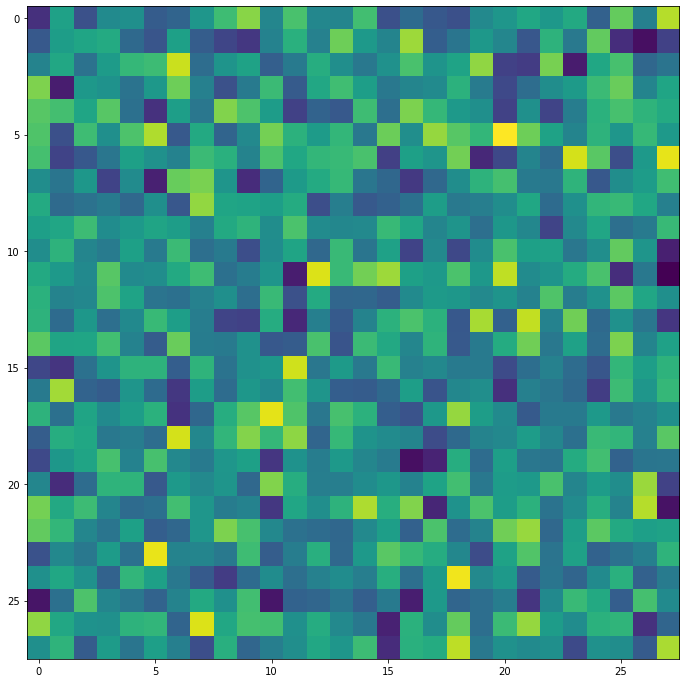

In [47]:

# eval prediction
T = 200     # steps

seq, seq2, step, orig, no_emb_seq = get_random_seq_diffusion(x_train[1])

noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev = 1.0, dtype=tf.float32)


#sinVec2Float(seq, 8)


#step = tf.expand_dims(tf.expand_dims(step, axis=0), axis=0)

tf.print("Start")
prediction = tf.expand_dims(noise, axis=0)

print(prediction.shape)

alphas = []

beta_t = 0.0      
alpha_t = 1.0
std_mod = 0.001

for k in range(T):
    beta_t = k / T * std_mod
    alpha_t *= 1.0 - beta_t
    alphas.append(alpha_t)
    
    
#print(alphas[:10])

for i in reversed(range(1, T)): 

    
    beta_t = i / tf.cast(T, tf.float32) * std_mod
    step_i = tf.expand_dims(tf.expand_dims(i, axis=0), axis=0)

    
    inv_noise = model(prediction, training=False) * (beta_t / tf.sqrt(1.0 - alphas[i]))
    prediction = (prediction - inv_noise) / tf.sqrt(1.0 - beta_t) 
    
    
    min_val = tf.math.reduce_min(prediction)
    max_val = tf.math.reduce_max(prediction)
    std = tf.math.reduce_std(prediction)
    
    #prediction = (prediction - min_val) / (max_val - min_val + 1e-6) * 2.0 - 1.0
    
    prediction = tf.clip_by_value(prediction, -8.0, 8.0)
    #prediction = (prediction - tf.reduce_mean(prediction)) / tf.math.reduce_std(prediction)
    
    
    #tf.print("Inv noise std:", tf.math.reduce_std(inv_noise))
    if i % 10 == 1:
        tf.print("Iter: ", i, "min:", min_val, "max:", max_val, "std:", std)
    
min_val = tf.math.reduce_min(prediction)
max_val = tf.math.reduce_max(prediction)
prediction = (prediction - min_val) / (max_val - min_val + 1e-6)

tf.print("End")
prediction = prediction[0]
print(prediction.shape)


fig = plt.figure(figsize=(20, 12))
plt.imshow(prediction)









(1024, 2)
(1024, 2, 1)
(1024, 2)


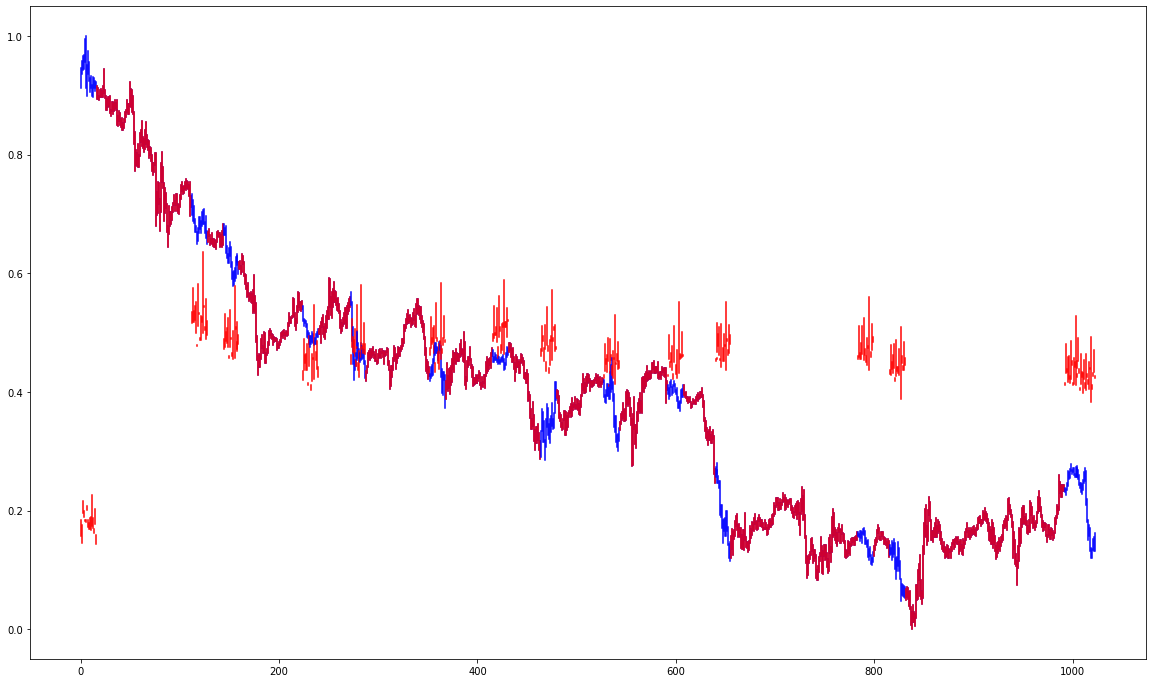

In [540]:

# eval prediction - show candles

def binVec2Float(input, bin_size):
    vec = np.power(2.0, np.arange(bin_size-1, -1, -1))

    output = []
    for i in input:
        x = np.round_(i) > 0
        output.append(np.dot(vec, x) / 2**bin_size)
    
    return np.array(output)
        
        
sample = get_random_seq(M15_candles)[0]

print(sample.shape)
print(tf.expand_dims(sample, axis=-1).shape)

prediction = model(tf.expand_dims(sample, axis=0), training=True)[0]
#prediction = model.predict(tf.expand_dims(sample, axis=0))[0]
print(sample.shape)

bin_size = 8
N = 3


#output_L = binVec2Float(prediction[:, :bin_size], bin_size)
#output_H = binVec2Float(prediction[:, bin_size:], bin_size)

#real_L = binVec2Float(sample[:, :bin_size], bin_size)
#real_H = binVec2Float(sample[:, bin_size:], bin_size)




fig = plt.figure(figsize=(20, 12))

for i in range(sample.shape[0]):
    plt.plot((i, i), (sample[i, 0], sample[i, 1]), color="blue")
    plt.plot((i, i), (prediction[i, 0], prediction[i, 1]), color="red")







#for i in range(10):
#    plt.plot(np.squeeze(prediction[i]), color="red")
    






In [35]:
# weights

W = model.get_weights()[5]
W = np.array(W, dtype="object")

print(len(W))
print(W)

#print(np.amin(W), np.amax(W))

32
[[0.04836098477244377 -0.05677817016839981 -0.021130971610546112 ...
  -0.0508415661752224 -0.02099577523767948 -0.008478721603751183]
 [0.027959736064076424 -0.015071945264935493 -0.018230613321065903 ...
  0.02411341667175293 0.001067331526428461 0.04032711312174797]
 [0.009525771252810955 0.015670353546738625 -0.02815265953540802 ...
  0.04129430651664734 -0.05244029313325882 0.018685221672058105]
 ...
 [0.02767977863550186 0.004733916837722063 -0.023540647700428963 ...
  0.01896263100206852 0.013021315447986126 0.018483271822333336]
 [0.00801731925457716 -0.013094963505864143 -0.002027214737609029 ...
  0.036327313631772995 0.0286114439368248 -0.007302300538867712]
 [-0.0006706054555252194 -0.024403410032391548 0.019239604473114014 ...
  0.004323917906731367 -0.013237054459750652 0.0038881914224475622]]


2.114319936119244
0.0 1.0


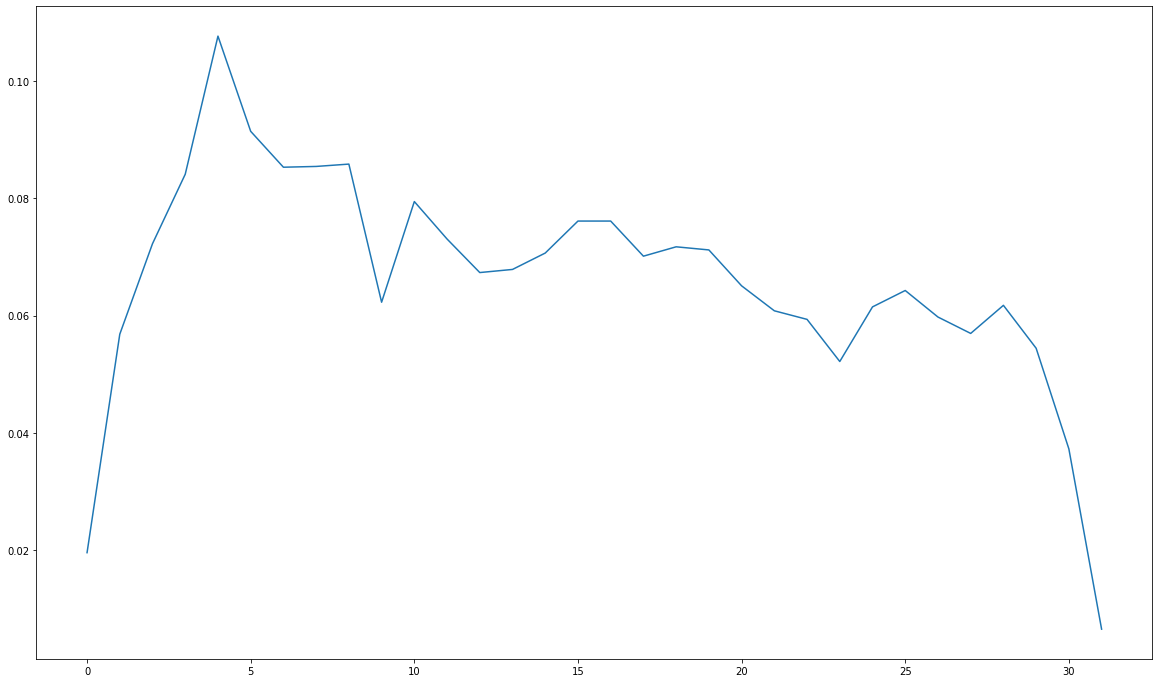

In [43]:
# average distribution


avs = np.average(Y_data, axis=0)
#print("Model:", avs)

sum = np.sum(Y_data) / Y_data.shape[0] 
print(sum)

print(np.amin(X_dataset), np.amax(X_dataset))



fig = plt.figure(figsize=(20, 12))
#plt.plot(point_sequence[start_index:start_index+interval_size*2])                # plot price

plt.plot(avs)


#Xa = [0, interval_size * 2]
#Ya = [entry, entry]
#plt.plot(Xa, Ya, color='blue')



In [481]:

# Reversed - eval prediction


balance = 1000 # in $
risk = 0.01
RR = 1.0

wins = 0
losses = 0
trades_without_NN = 0



prediction = model.predict(X_reversed_dataset)

print(X_reversed_dataset.shape, prediction.shape)
#print(prediction[0:40])


for i, res in enumerate(Y_data):

    margin = balance * risk
    
    if prediction[i] < 0.5:   # noped by AI
        continue
    
    
    if res == 1:
        balance = balance + margin*RR
        wins = wins+1
        #print(i, "- Win", balance)
    if res == -1:
        balance = balance - margin
        losses=losses+1
        #print(i, "- Loss", balance)
        
        


print("Balance:", balance)
print(wins+losses,"trades taken out of", Y_data.shape[0], "setups")
print("Winrate:", wins / (wins+losses))







(28987, 64, 1) (28987, 1)
Balance: 691.6231154730004
2174 trades taken out of 28987 setups
Winrate: 0.49402023919043236


In [421]:
#@jit(nopython=True)
def getDistribution(dataSeq, startCandle, entry, stop):
       
    
    bounce_points = set([int(x) for x in range(0)])
    
    limit = 10000                                       # candles
    resolution = 32
    
    if entry == stop:
        return np.zeros(resolution, dtype=np.float32)
    
    long = entry > stop                                 # for buys
    last_deepest_reaction = np.inf if long else 0.0     # lowest for sells, highest for buys
    
    for i in range(startCandle, len(dataSeq)):
        price = dataSeq[i]
        
        if i > startCandle + limit:
            break
        
        price_in_zone = priceInBetween(price, entry, stop)
        
        if price_in_zone == 0:
            if long:
                if price < last_deepest_reaction:
                    last_deepest_reaction = price
                    bounce_points.add(i)
            else:
                if price > last_deepest_reaction:
                    last_deepest_reaction = price
                    bounce_points.add(i)
                
        elif price_in_zone == -1:
            break
        
    bounce_points.add(i)
    bounce_points = sorted(list(bounce_points))                   # remove duplicates
    
    bounce_sizes = [float(x) for x in range(0)]
    
    for i in range(len(bounce_points)-1):
        x1 = bounce_points[i]
        x2 = bounce_points[i+1] + 1
        
        if x2-x1 < 2:
            bounce_sizes.append(0.0)
            continue
        
        max_retrace_size = getExtremumLimit(dataSeq, x1, x2, long=(entry > stop) )
        
        max_retrace_size = max_retrace_size / (entry - stop)
        bounce_sizes.append(max_retrace_size)
        
        
    bounce_points.pop()
       
    
    bounce_points = np.array(bounce_points)
    bounce_sizes = np.array(bounce_sizes)
    
    print("bounce_points:", bounce_points)
    print("bounce_sizes:", bounce_sizes)
    
    bounce_points = bounce_points[bounce_sizes > 0.3]
    print("Filtered bounce_points:", bounce_points)
    
    result = np.zeros(resolution, dtype=np.float32)
    
    for i in bounce_points:
        index = int((dataSeq[i] - entry) / (stop - entry) * (resolution-1))
        result[index] = 1.0
        
    #print(result)
        
    return bounce_points, bounce_sizes, result

    
    
    
                                   










# longs - closer to the end of vector = closer to stop
# shorts - closer to the end of vector = closer to stop






startCandle = 1700
entry = 1.348
stop = 1.35

print(point_sequence[startCandle])

bounce_points, bounce_sizes, result = getDistribution(point_sequence, startCandle=startCandle+1, entry=entry, stop=stop)
bounce_points = sorted(list(set(bounce_points)))

#result = np.convolve(result, [0.25, 0.5, 0.25], 'same')     # blur

print(result)

print("Calculated moves:", len(moves))


1.3487
bounce_points: [1701 1702 1709 1711 1720 1776]
bounce_sizes: [-0.    0.25  0.05  0.2   0.65  9.75]
Filtered bounce_points: [1720 1776]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0.]
Calculated moves: 4768467


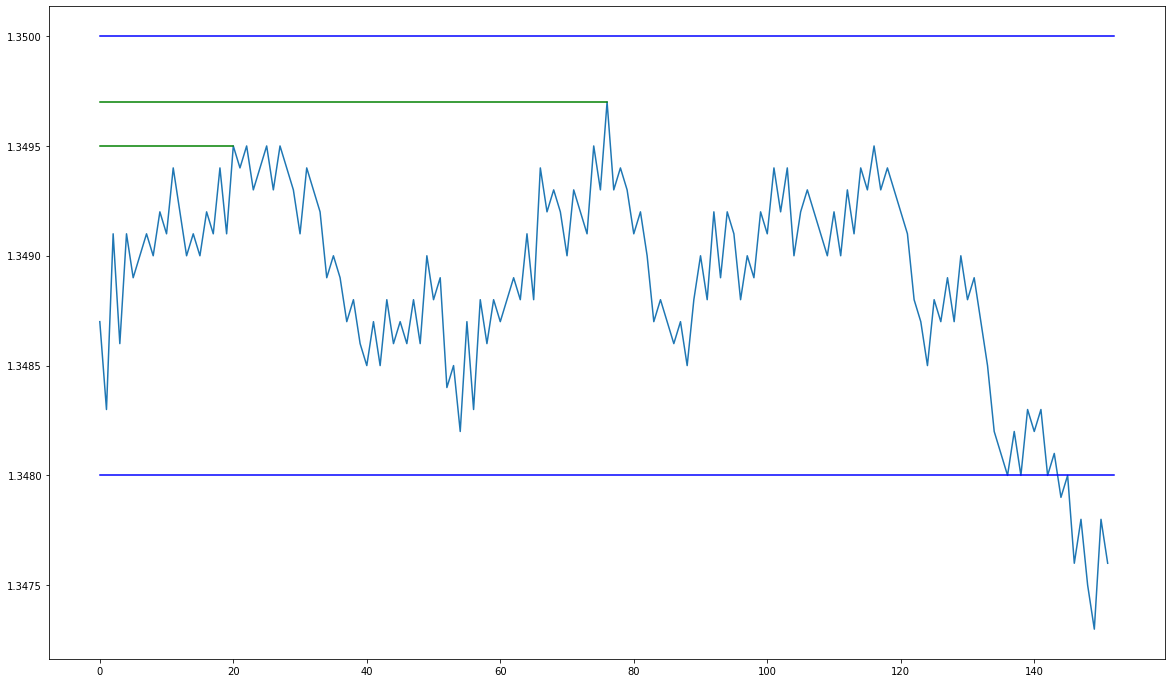

In [422]:
# Try resampling part of history

start_index = startCandle  
interval_size = np.amax(bounce_points) - start_index


fig = plt.figure(figsize=(20, 12))
plt.plot(point_sequence[start_index:start_index+interval_size*2])                # plot price



Xa = [0, interval_size * 2]
Ya = [entry, entry]
plt.plot(Xa, Ya, color='blue')

Xa = [0, interval_size * 2]
Ya = [stop, stop]
plt.plot(Xa, Ya, color='blue')

for i in bounce_points:
    Xa = [0, i-start_index]
    Ya = [point_sequence[i], point_sequence[i]]
    plt.plot(Xa, Ya, color='green')
    

#for i in bounce_sizes:
#    Xa = [100, 100 + interval_size]
#    Ya = [1.351, 1.351]
#    plt.plot(Xa, Ya, color='blue')

#Xa = [100, 100 + interval_size]
#Ya = [point_sequence[start_index], point_sequence[start_index]]
#plt.plot(Xa, Ya, color='red')
    




0 input_1 [(None, 64, 1)]
1 gaussian_noise (None, 64, 1)
2 gru (None, 64, 8)
3 reshape (None, 64, 1, 8)
4 inverted_residual (None, 64, 1, 8)
5 inverted_residual_1 (None, 64, 1, 8)
6 inverted_residual_2 (None, 64, 1, 8)
7 max_pooling2d (None, 32, 1, 8)
8 inverted_residual_3 (None, 32, 1, 8)
9 inverted_residual_4 (None, 32, 1, 8)
10 inverted_residual_5 (None, 32, 1, 8)
11 max_pooling2d_1 (None, 16, 1, 8)
12 inverted_residual_6 (None, 16, 1, 8)
13 inverted_residual_7 (None, 16, 1, 8)
14 inverted_residual_8 (None, 16, 1, 8)
15 reshape_1 (None, 16, 8)
16 position_embedding (None, 16, 8)
17 transformer_block (None, 16, 8)
18 transformer_block_1 (None, 16, 8)
19 transformer_block_2 (None, 16, 8)
20 flatten (None, 128)
21 dropout_6 (None, 128)
22 dense_6 (None, 32)
All activations: 23
Activations: (3, 64, 1) 0.0 1.0
Activations: (3, 64, 1) 0.0 1.0
Activations: (3, 64, 8) -0.12479696 0.22481865
Activations: (3, 64, 1, 8) -0.12479696 0.22481865
Activations: (3, 64, 1, 8) -0.12005793 0.22121687
A

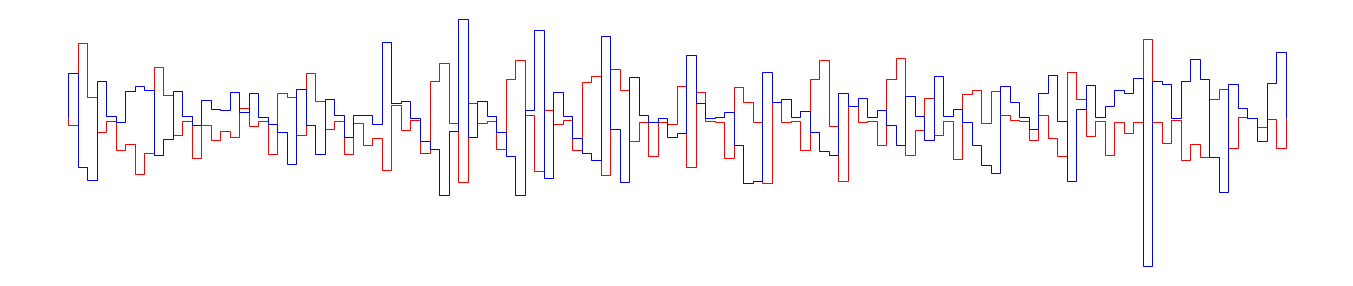

In [454]:





# Show layers output

"""

"""





mdl = model
inp = X_dataset[0:3]
       
layer_outputs = [layer.output for layer in mdl.layers[:]] 
generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_activations = Model(inputs=mdl.input, outputs=layer_outputs)
    activations = get_activations.predict(inp)



print("All activations:", len(activations))
for i in activations:
    print("Activations:", i.shape, np.amin(i), np.amax(i))
    
    
    
layer_i = 20
print((activations[layer_i][0].T).shape)
print((activations[layer_i][1].T).shape)

x1 = (activations[layer_i][0].T)
x2 = (activations[layer_i][1].T)

x = [np.array(x1), np.array(x2)]


#x = activations[0][0]
#print("x", x.shape)

#print("Min, max: ", np.min(x), np.max(x))
#print("AE: ", x[0, :24, :24])






fig = plt.figure(figsize=(24, 5))

plt.stairs(x[0].T, color="red")
plt.stairs(x[1].T-x[0].T, color="blue")

plt.axis('off')

print("Done")








In [455]:
print(np.unique(Y_data, return_counts=True))

(array([0., 1.], dtype=float32), array([856314,  77062]))


In [ ]:
# Show output interval

print("### ENCODER ###")
   
layer_outputs = [layer.output for layer in encoder.layers[:]] 

generate = True
if generate:
    get_activations = Model(inputs=encoder.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(next(data_iter)[0], axis=0))
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(encoder.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')



print(" \n\n\n### DECODER ###")


#inp = tf.random.stateless_uniform(dec_input_shape, minval=0.0, maxval=1.0, dtype=tf.float32)
inp = encoded

layer_outputs = [layer.output for layer in decoder.layers[:]] 

generate = True
if generate:
    get_activations = Model(inputs=decoder.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(inp, axis=0))
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(decoder.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')



print("Done")









In [ ]:
## show kernels


mdl = encoder
inp = X[0]   #encoded
layer_weights = [layer.weights for layer in mdl.layers[:]] 

generate = True
if generate:
    #for i, l in enumerate(mdl.layers):
    #    print(i, l.name, l.output_shape)

    get_weights_model = Model(inputs=mdl.input, outputs=layer_weights)
    weights = get_weights_model.predict(np.expand_dims(inp, axis=0))

layer_num = 4

weights = layer_weights[2]
print(weights)



#print(weights[layer_num].shape)

x = np.array(weights)[0]
x = np.transpose(x, (2, 0, 1, 3))[0]
x = np.transpose(x, (2, 1, 0))   # transpose



aspect_ratio = 64 / 64

x_count = 4
y_size = 32 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    fig.add_subplot(x.shape[0], x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')
    


print("Done")





In [ ]:
result = AE.predict(X[:2])[0]

difference = X[0]-result

print("AE: ", np.min(X[0]), np.max(X[0]))
print("AE: ", np.min(result), np.max(result))
print("Diff: ", np.min(difference), np.max(difference))

aspect_ratio = 256 / 64
y_size = 32

fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))
plt.imshow(difference, cmap='gray')
plt.axis('off')

print("Done")


In [ ]:
# Sample decoder



N = 12
enc = tf.random.normal([N, 4, 256], dtype=tf.float16) * 1.0
x = trans_block2(enc)

#tf.print(x)

x = decoder(x)


aspect_ratio = x.shape[1] / x.shape[2]  # 2.0 -> vyska = 2 * sirka
channel_count = x.shape[0]

x_count = 4 # charts per row
y_count = channel_count // x_count + 1



fig = plt.figure(figsize=(24, int(24 * aspect_ratio * y_count / x_count)))

for i, xr in enumerate(x):

    fig.add_subplot(y_count, x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')

print("Done")








In [ ]:
# Try resampling part of history

start_index = 1    
interval_size = 682 - 1
res_size = 256

HL_list = resampleMoves(moves, start_index, interval_size, res_size)

print("len:", len(HL_list))

fig = plt.figure(figsize=(20, 12))
shift = 0
plt.plot(point_sequence[start_index-shift:start_index+interval_size+shift])                # plot price

for i in range(len(HL_list)-1):
    Xa = [HL_list[i]-start_index+shift, HL_list[i+1]-start_index+shift]
    Ya = [point_sequence[HL_list[i]], point_sequence[HL_list[i+1]]]

    plt.plot(Xa, Ya, color='red')                                   # plot price movements  
    
    




In [103]:

# Visualize random sample from dataset

random_index = randint(0, len(HL_list))                       # get random FTR


ftr = mvs[random_index]
print(random_index)

HL_list = resampleMoves(moves, ftr[1], ftr[3]-ftr[1], res_size)

start_index = HL_list[0]
end_index = HL_list[-1]
print(start_index, end_index)

###### show result
print("Len", len(HL_list))

shift = int((end_index-start_index) * 10)

fig = plt.figure(figsize=(20, 12))
plt.plot(point_sequence[start_index-shift:end_index+shift])                # plot price

for i in range(len(HL_list)-1):
    #scale_coef = interval_size / res_size
    #Xa = [i*scale_coef, (i+1)*scale_coef]             
    
    Xa = [HL_list[i]-start_index+shift, HL_list[i+1]-start_index+shift]
    Ya = [point_sequence[HL_list[i]], point_sequence[HL_list[i+1]]]

    plt.plot(Xa, Ya, color='red')                                   # plot price movements  
      
Xa = [HL_list[0]-start_index, HL_list[-1]-start_index+shift*2]
Ya = [point_sequence[HL_list[0]], point_sequence[HL_list[0]]]
plt.plot(Xa, Ya, color='red')



36


IndexError: index 0 is out of bounds for axis 0 with size 0

X shape (2, 256, 16)
Output shape (2, 256, 16)
Mask shape (2, 256, 16)
reconstructed shape (2, 256, 16)


(-0.5, 255.5, 15.5, -0.5)

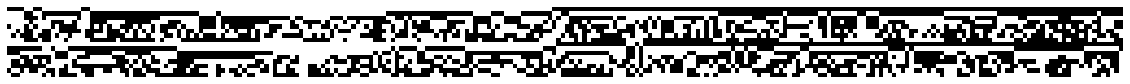

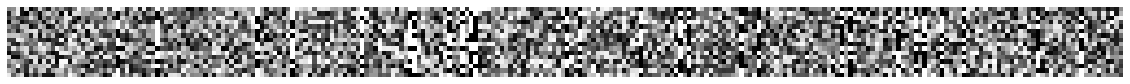

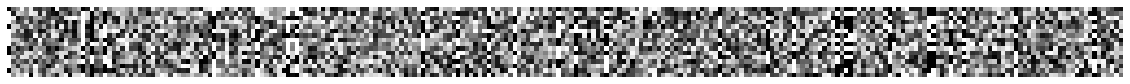

In [327]:

class RandomMask2(Layer):
    def __init__(self, maxLen=64, masked_rate=0.75, blur_kernel = 3):
        super(RandomMask2, self).__init__()

        self.maskedRate = masked_rate
        self.maskLayer = Masking(mask_value=0.0)
        self.rnd = tf.random.get_global_generator()
        self.maxLen = maxLen
        self.blur_kernel = blur_kernel
        self.trainable = False
       

    def call(self, inputs):

        input_dims = [tf.shape(inputs)[-1], tf.shape(inputs)[-2]] # transposed
        mask = self.rnd.uniform(shape=(self.maxLen,), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
        mask = tf.math.greater(mask, self.maskedRate)
        mask = tf.cast(mask, tf.dtypes.float32)
        
        mask = tf.transpose(tf.ones(input_dims) * mask)
        
        blured = tfa.image.mean_filter2d(inputs, filter_shape = (1, self.blur_kernel))

        return inputs * mask + blured * (1.0 - mask)


    def get_config(self):
        cfg = super(RandomMask2, self).get_config()
        cfg.update({'maskedRate': self.maskedRate,
                    'blur_kernel': self.blur_kernel,
        	        'maxLen': self.maxLen})
        return cfg



  
    

x = get_random_seq(M15_candles)
x = tf.cast(x, dtype=tf.float32)
print("X shape", x.shape)

rand_mask = RandomMask(256, 0.1)
restoreLayer = RestoreUnmaskedTokens(256)

#x = tf.expand_dims(x, axis=0)

output, mask = rand_mask(x, training=True)

print("Output shape", output.shape)
print("Mask shape", mask.shape)



reconstructed = tf.random.uniform(shape=(2, 256, 16), minval=0.0, maxval=1.0, dtype=model_dtype) 
print("reconstructed shape", reconstructed.shape)

restored = restoreLayer([reconstructed, x, mask], training=True)



fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(x[0]), cmap='gray')
plt.axis('off')

"""
fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(mask[0]), cmap='gray')
plt.axis('off')

fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(output[0]), cmap='gray')
plt.axis('off')

fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(reconstructed[0]), cmap='gray')
plt.axis('off')
"""



fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(restored[0]), cmap='gray')
plt.axis('off')


fig = plt.figure(figsize=(20, 30))
plt.imshow(tf.transpose(restored[1]), cmap='gray')
plt.axis('off')




In [ ]:
# test


start_index = 15000
interval_size = 2000

diff = np.diff(sequence[start_index:start_index+interval_size])

fig = plt.figure(figsize=(20, 12))
plt.plot(sequence[start_index:start_index+interval_size])                # plot price
plt.plot(diff + 1.312) 

#plt.plot(Xa, Ya, color='red')                                   # plot price movements  
      

In [ ]:
# Clear memory

err = 0.07          # losses  1.22 -> 1.17

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + tf.abs(err)) * 100 )     
    
print("\n\n\n")

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + 100 * tf.abs(err)) * 10 ) 
    
    # tf.math.reduce_mean(tf.math.log(1.0 + 100 * tf.abs(spec1-spec2))) * 10 


#loss = 4.59
#print("Error: ", tf.math.exp(loss / 100.0) - 1)

#del X, Y
#gc.collect()

# %debug          commands -     h

#model.load_weights(projDir + 'models/' + "working_CNN_AE")

#print(tmps[0])
#with open(projDir + 'data/train_X_hartley.npy', 'wb') as f:
#  np.save(f, X)

#with open(projDir + 'data/valid_X_hartley.npy', 'wb') as f:
#  np.save(f, valX)

In [ ]:
# Load data info


import os
from pathlib import Path
import pandas as pd

import re


def load_data(data_dir):
    np.random.seed = 1
    

    pattern  =  re.compile("(.+[\/\\\\])?(\w+)[\/\\\\]([^_]+)_.+wav")
    all_files = []

    """
    for root, dirs, files in tqdm(os.walk(data_dir + "train/audio/")):
        for name in files:
            all_files.append(root + '/' + name)

    with open(data_dir + "train/all_files.txt", "w") as f:
      for s in all_files:
          f.write(str(s) +"\n")
    """


    with open(data_dir + 'train/all_files.txt', "r") as f:
      for line in f:
        all_files.append(line.strip())      # rychly nacitani seznamu

    with open(data_dir + 'train/validation_list.txt', 'r') as fin:
        validation_files = fin.readlines()
        

        
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))  
            
    
    possible = set(POSSIBLE_LABELS)
    
    train, val = [], []
    
    for entry in tqdm(all_files):
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            #print(entry)
            
            if label == '_background_noise_':     # ignore for now
                continue
                
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, uid, entry)  # struct
            

            if uid in valset:    
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    

    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    
    return train_df, valid_df 



train_df, valid_df = load_data(projDir + 'data/')


#valid_df.label.value_counts()

#data_distribution = train_df.label.value_counts() / len(train_df)

#print(data_distribution, '\n')

train_df.head(1)

#!ls gdrive
print(len(valid_df))

train_df.label.value_counts()


In [ ]:
# Generator class


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, filename, batch_size = 32, shuffle = True):
        'Initialization'

        self.batch_size = batch_size

        self.allX = np.load(projDir + "data/" + filename + "_X.npy")
        self.allY = np.load(projDir + "data/" + filename + "_Y.npy")

        self.size = self.allX.shape[0]

        self.indexes = np.arange(self.size)
        self.shuffle = shuffle
        self.on_epoch_end()



    def __len__(self):
        'Denotes the number of batches per epoch'

        return int(np.floor(self.size / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)


    def on_epoch_end(self):
        'Updates indexes after each epoch'

        if self.shuffle == True:
            np.random.shuffle(self.indexes)



    def __data_generation(self, IDs):


        # Initialization
        #tmpX = np.diff(np.array(self.allX)[IDs], axis=-2, prepend=0) 

        tmpX = np.array(self.allX)[IDs]
        tmpY = np.array(self.allY)[IDs]

        #for ID in range(tmpX.shape[0]): 
        #  tmpX[ID] = augment_spectrogram_diff(tmpX[ID])
          # dalse augmentace


        return tmpX, tmpY


training_generator = DataGenerator("train", batch_size, shuffle=True)
validation_generator = DataGenerator("valid", batch_size, shuffle=False)

In [ ]:
# Load model


model = load_model(projDir + 'models/' + exp_name)
print('Loaded')

In [ ]:
# save model
exp_name = "moves_64_16_binary_0_69loss"
model.save_weights(projDir + 'weights/' + exp_name + '.hdf5')
model.save(projDir + 'models/' + exp_name)


print('Saved')



In [ ]:

# Wav -> Spectrogram


import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.playback import play
import librosa
from librosa import display



def process_wav_file(filename):

    melYsize = 128
    melXsize = 64

    desiredSR = 16000
    
    wav, sr = librosa.load(filename, sr = None)
    wav = librosa.resample(wav, sr, desiredSR)

    

    wav = fill_to_1sec(wav, desiredSR)  #make sure segment is 1 second 
    wav, oolk = librosa.effects.trim(wav, top_db=30)

    S = librosa.feature.melspectrogram(wav, sr = desiredSR, n_mels = melYsize, hop_length = desiredSR // melXsize, fmax = desiredSR / 2)[:, :melXsize] 
    S = librosa.power_to_db(S, ref = np.max) # prevod na log amplitudu v dB

    return np.array(-S, dtype='int8')




random_index = randint(0, valid_df.shape[0])
fileName = valid_df.wav_file[random_index]
spect = process_wav_file(fileName)
print("Spectrogram shape:", spect.shape)



#S = np.abs(librosa.stft(y)) # FFT  
#y_inv = librosa.griffinlim(np.abs(S)) # zpet do casove oblasti
#sf.write(out_fn, y_inv, samplingRate, 'PCM_16') # 24 bit



plt.figure(figsize=(12, 6))
plt.imshow(spect, cmap='gray', vmin=0, vmax=80, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()

AudioSegment.from_wav(fileName)


In [ ]:
# Evaluate random sample

random_index = randint(0, valid_df.shape[0])
fileName = valid_df.wav_file[random_index]

mel = np.transpose(process_wav_file(fileName))
mel = augment_spectrogram_diff(mel)


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play



In [ ]:
# Test

fileName = projDir + 'mySounds/go_1.wav'

mel = np.transpose(process_wav_file(fileName))

plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=0, vmax=80, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = augment_spectrogram_diff(mel)


plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=-26, vmax=26, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play


In [ ]:
# Evaluate accuracy for each keyword

#[valX, valY] = load_data_from_bin("DataAll_valid_128_64")

correctGuess = np.zeros(len(POSSIBLE_LABELS))
mistakeIDs = []

results = model.predict(valX)


ids = np.argmax(results, axis=1)
correctIDs = np.argmax(valY, axis=1)


#print(np.bincount(ids))
#print(np.bincount(correctIDs))


for i in range(len(valY)):
  if ids[i] == correctIDs[i]:
    correctGuess[ids[i]] = correctGuess[ids[i]] + 1
  else:
    mistakeIDs.append([i, ids[i], correctIDs[i]])

#print(correctGuess)
    
correctGuess = np.divide(correctGuess, np.bincount(correctIDs, minlength = len(POSSIBLE_LABELS)))



#correctGuess[30] = 0.0  # unknown zatim neni ve validation setu

print("\n")
print("Pravdepodobnost spravneho rozpoznani")
for i in range(len(correctGuess)):
  print(id2name[i], " %.2f" % (correctGuess[i] * 100), '%')

print("\n")
print("Stredni uspesnost: %.2f" % (sum(correctGuess) / len(correctGuess) * 100), '%')
print("\n")


random_index = randint(0, len(mistakeIDs))
fileName = valid_df.wav_file[mistakeIDs[random_index][0]]


with open("./mistakes.txt", "w") as f:
  for mID, g1, g2 in mistakeIDs:
    f.write(str(mID) +"\n")




In [ ]:
# index dataset

columns_list = ['date', 'time', 'open', 'high', 'low', 'close', 'idk']
wanted_list = ['date', 'time', 'high', 'low']


start_year = 2005
end_year = 2020


x = pd.DataFrame(columns=wanted_list)

for i in range(start_year, end_year+1):
    y = pd.read_csv(f"data/DAT_MT_EURUSD_M1_{i:04}.csv", names=columns_list)[wanted_list]
    x = x.append(y)
    print(f"Loading {i}")
    
    
x.reset_index(drop=True, inplace=True)

# adjust date

startDate = x.loc[0, 'date'] + "T" + x.loc[0, 'time']               # get the datetime of the very first candle
print("Start minute: ", startDate)
startDate = dt.strptime(startDate, "%Y.%m.%dT%H:%M").timestamp() // 60   # convert to minutes passed from 1.1.1970


dates = pd.DataFrame(x['date'] + "T" + x['time'])   # merge date and time string into isoformat
dates = dates.applymap(lambda row : dt.strptime(row, "%Y.%m.%dT%H:%M").timestamp() // 60 - startDate)   # replace date and time with offset from startDate in minutes

x = x.drop(['date', 'time'], axis=1)
x["tm"] = dates


print(x)
    
x.to_csv('history.csv', index=False)




    
# dates = pd.Series(dicti, name = 'date')
#print(x[['open', 'close']])
# df.loc[[1,3,5], ['A']]
# df.loc[:5, ['A']]
# df > 1.5    # out - df with true/false
# df[df > 1.5] # get all items on cond
# cond_on_rows = df['B'] > 1.5  # then df.loc[cond_on_rows, :] - get all items

# first_cond = (df['B'] > 1.25).rename('C1')
# second_cond = (df['B'] < 1.75).rename('C2')
# dual_conds = (first_cond & second_cond).rename('C1 & C2')

# pd.concat([first_cond, second_cond, dual_conds], axis = 1)

# df = pd.DataFrame([1,2,6,9,2], index = ['2020-10-01', '2020-10-02', '2020-10-04', '2020-10-06', '2020-10-07'], columns = ['Total Items Saled'])
# df.T  # transpose

# df.append(dates)

# df = df.fillna(0)   # replace nan with 0         
# df.drop('date')     # drop row
# df.drop(df.columns[[0]], axis=1, inplace=True) # drop column 0

# df.sort_index(axis = 1)

#g = g.T.append(tm.T, ignore_index=True).T
#g['tm'] = g.apply(lambda row : g['date'] + "T" + g['time'], axis = 1)

#print(tm)
#g.T.append(dates).drop('date').T


#s = "2020.12.31T6:43"
#out = dt.strptime(s, "%Y.%m.%dT%H:%M").isoformat()

#print(out)



# event list - only creating L/H and breaching L/H
# event: price of H/L, time until breach





#(x.loc[5, ['low', 'high']])
# df.iloc[:5, [1, 2]]  # column 1, 2


"""
  
try:
    with open(data_dir + 'all_files.txt', "r") as f:
        for line in f:
            all_files.append(line.strip())      # rychly nacitani seznamu
        indexed = True
except Exception as e:
    print(e)
        

if not indexed:
    for root, dirs, files in os.walk(data_dir + "train/audio/"):
        for name in files:
            root = root.replace("./", "")
            all_files.append(root.replace("/.", "   ") + '/' + name)
                
"""

# open - 1
# high - 2 - 100%
# low  - 3
# close -4



In [ ]:
# show H/Ls


tf.print(NN_input.shape)


#N = range(0, 300)


fig = plt.figure(figsize=(20, 12))

plt.plot(NN_input[0:1000, 0])




#plt.scatter(range(1000), NN_input[0:1000, 0], s=NN_input[0:1000, 2] * 10000, color='green')

#N = range(200)

#plt.plot(data[N], data[N, 1])
#plt.scatter(tst[N, 3], tst[N, 1], color='red')

#N = range(0, 29)
#plt.scatter(brokentst[N, 2], brokentst[N, 1], s=brokentst[N, 3]*10)


#plt.scatter(min_list[N, 0]*2, min_list[N, 1], s=min_list[N, 10]*10, color='green')
#plt.scatter(min_list[N, 2], min_list[N, 3], s=min_list[N, 10], color='blue')
#plt.scatter(min_list[N, 4], min_list[N, 5], s=min_list[N, 10], color='red')
#plt.scatter(min_list[N, 6]*2, min_list[N, 7], s=min_list[N, 10]*10, color='yellow')
#plt.scatter(min_list[N, 8]*2, min_list[N, 9], s=min_list[N, 10]*10, color='black')

#print(min_list[:100])




